## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [373]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import swifter
import en_core_web_sm
nlp = en_core_web_sm.load()

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_columns', 500)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [429]:
# Opening JSON file 
f = open('../Case-Study-Ticket-Classification/complaints-2021-05-14_08_16.json') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [430]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head()

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [431]:
#print the column names

df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [432]:
#Assign new column names
df.columns = df.columns.str.replace('_', '', 1)
df.columns = df.columns.str.replace('source.', '')

In [433]:
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [434]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [435]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notna()]
df = df.reset_index(drop = True)

In [436]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [437]:
# Write your function here to clean the text and remove all the unnecessary elements.


model = spacy.load('en_core_web_sm',disable=['parser','ner'])

def clean_text(col):
    # converting the text to lowercase
    df[col] = df[col].apply(lambda c : c.lower())     
    
    # removing text which is present in square brackets using the regex
    df[col] = df[col].apply(lambda c : re.sub('\[(.*?)\]', "", c))
    
    # removing all the punctuations from the text using the regex
    punct = "[" + re.escape(string.punctuation) + "]"
    df[col] = df[col].apply(lambda c : re.sub(punct, "", c))
    
    # removing words which contains digits/numbers
    df[col] = df[col].apply(lambda c : re.sub('\S*\d+\S*', "", c))

In [438]:
#Write your function to Lemmatize the texts

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):      
    tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(tokens)

In [440]:
# Now, Lets apply the lemmatize_text function
df['lem_complaint'] = df['complaint_what_happened'].swifter.apply(lambda x : lemmatize_text(x))

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

'upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled'

In [441]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame(data={'Complaints': df['complaint_what_happened'], 'lemmatized_complaints': df['lem_complaint'] })
df_clean.head()

,Complaints,lemmatized_complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [442]:
#Write your function to extract the POS tags 


def extract_POS(sentence):
    words = []
    doc = model(sentence)
    
    for token in doc:
        if token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
            words.append(token.text)
            
    sent = " ".join(words)        
    return sent



In [443]:
#Creating new column Complaint_POS by applying the above created function on complaint_what_happened column

df_clean['complaint_POS'] = df_clean['Complaints'].swifter.apply(lambda x : extract_POS(x))
df_clean['complaint_POS'][1]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

'card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent'

In [444]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing 
#POS tags.
df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx ticket offer ticket rewards card informat...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [445]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length']  = df_clean['Complaints'].str.len()

df_clean['complaint_length'].iplot(
    kind='hist',
    bins=200,
    xTitle='Complaint length',
    linecolor='black',
    yTitle='count',
    title='Complaint Text Length Distribution')

In [446]:
df_clean.head(10)

,Complaints,lemmatized_complaints,complaint_POS,complaint_length
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,337
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx ticket offer ticket rewards card informat...,1433
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,456
5,can you please remove inquiry,please remove inquiry,inquiry,29
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,2224
7,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...,1350
8,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using chase ...,xxxx payment retailer chase pay xxxx chase web...,3461
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,127


#### Find the top 40 words by frequency among all the articles after processing the text.

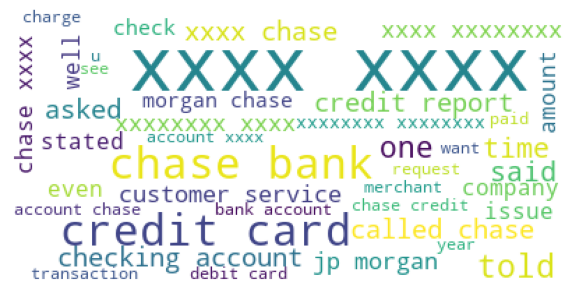

In [447]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_complaints = ' '.join(df_clean['lemmatized_complaints'].str.lower())

wordcloud = WordCloud(background_color="white", max_words=40).generate(all_complaints)
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [448]:
#Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [449]:
complaints = ''.join(str(df_clean['lemmatized_complaints'].tolist()))

In [450]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# DOUBT
# Use the CountVectorizer function to get the unigram words
def get_unigrams(docs, n):
    vector = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each unigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

unigrams = get_unigrams(df_clean['complaint_POS'], 30)

In [451]:
#Print the top 10 words in the unigram frequency
unigrams_df = pd.DataFrame(unigrams, columns=['Word', 'Count'])
unigrams_df.head(10)

,Word,Count
0,xxxx,134175
1,chase,72834
2,account,41876
3,credit,32230
4,xxxxxxxx,27707
5,card,26809
6,bank,26411
7,payment,13962
8,time,11964
9,money,11937


In [452]:
#Find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_bigrams(docs, n):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each bigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of bigram words and frequency by calling the above func
bigrams = get_bigrams(df_clean['complaint_POS'], 30)


In [453]:
#Print the top 10 words in the bigram frequency
bigrams_df = pd.DataFrame(bigrams, columns=['word', 'count'])
bigrams_df.head(10)

,word,count
0,xxxx xxxx,59527
1,chase bank,12047
2,credit card,10960
3,xxxx chase,5125
4,chase credit,3559
5,xxxxxxxx xxxx,3541
6,account chase,3477
7,credit report,3245
8,chase xxxx,3167
9,customer service,3026


In [454]:
#Find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_trigrams(docs, n):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each trigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of trigram words and frequency by calling the above func
trigrams = get_trigrams(df_clean['complaint_POS'], 30)

In [455]:
#Print the top 10 words in the trigram frequency
trigrams_df = pd.DataFrame(trigrams, columns=['word', 'count'])
trigrams_df.head(10)

,word,count
0,xxxx xxxx xxxx,29634
1,chase credit card,2120
2,jp morgan chase,2017
3,xxxx xxxx chase,1955
4,xxxxxxxx xxxx xxxx,1643
5,xxxx xxxx xxxxxxxx,1337
6,chase xxxx xxxx,1143
7,account xxxx xxxx,1039
8,chase bank xxxx,1006
9,xxxx xxxxxxxx xxxx,959


##### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [456]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [457]:
#All masked texts has been removed
df_clean

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,337,card agent anniversary date agent information ...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx ticket offer ticket rewards card informat...,1433,ticket offer ticket rewards card information ...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,456,son check chase account fund chase bank accoun...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,650,chase card customer decade solicitations credi...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx chas visa credit card provi...,2067,wednesday chas visa credit card provider clai...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,2296,pay risk consumers chase bank app chase years ...
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom xx...,2009,credit yrs chase credit cards chase freedom p...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [458]:
#Initialising TfidfVectorizer 

tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [459]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [460]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [461]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40) 

In [462]:
W = nmf_model.fit_transform(dtm) # Document-topic matrix
H = nmf_model.components_        # Topic-term matrix

type(tfidf.get_feature_names())

list

In [463]:
#Print the Top15 words for each of the topics
# Using the same approach that has been used in course notebooks
# get the feature names
words = np.array(tfidf.get_feature_names())

# create a dataframe with featues and the topic-term matrix H
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,bank,chase,check,money,funds,branch,checking,deposit,accounts,business,number,days,checks,fraud
Topic 1,credit,report,inquiry,card,inquiries,score,cards,accounts,chase,account,debt,limit,reporting,information,bureaus
Topic 2,loan,mortgage,chase,home,modification,property,payments,foreclosure,bank,years,house,rate,letter,morgan,time
Topic 3,card,chase,charges,charge,credit,dispute,fraud,merchant,transaction,company,fee,purchase,phone,service,number
Topic 4,payment,payments,balance,month,fees,fee,statement,date,auto,chase,time,account,days,months,day


In [464]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_df = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics) ])


In [465]:
topic_df.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,0.022883,0.015897,0.015266,0.002773,0.009073
1,0.007376,0.001492,0.001041,0.019952,0.003852
2,0.000000,0.038510,0.001617,0.028019,0.000000
3,0.019427,0.054436,0.014379,0.022913,0.000000
4,0.069601,0.000000,0.008406,0.007534,0.000000


In [466]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1)

In [467]:
df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,0
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,337,card agent anniversary date agent information ...,3
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,1
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx ticket offer ticket rewards card informat...,1433,ticket offer ticket rewards card information ...,1
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,456,son check chase account fund chase bank accoun...,0


In [472]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,Bank Account services
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,50,account chase auto,Bank Account services
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,2224,notice jp morgan chase account debit card tues...,Bank Account services
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,456,son check chase account fund chase bank accoun...,Bank Account services
12,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account chase bank xxxx code bonus xxxxxxxx te...,403,account chase bank code bonus terms account ...,Bank Account services
5,can you please remove inquiry,please remove inquiry,inquiry,29,inquiry,Credit card or prepaid card
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,Credit card or prepaid card
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,127,chase credit card data credit report company i...,Credit card or prepaid card
11,i have reached out to xxxx several times in at...,reached xxxx several time attempt fraudulent i...,times attempt inquiry creditor inquiry report ...,735,times attempt inquiry creditor inquiry report ...,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx ticket offer ticket rewards card informat...,1433,ticket offer ticket rewards card information ...,Credit card or prepaid card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [473]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0 : 'Bank Account services',
                1 : 'Credit card or prepaid card' ,
                2 : 'Mortgage/ Loan',
                3 : 'Theft/Dispute Reporting' , 
                4 : 'Others'}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [474]:
df_clean

,Complaints,lemmatized_complaints,complaint_POS,complaint_length,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop bank cardmember se...,475,morning name stop bank cardmember services d...,NaN
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,337,card agent anniversary date agent information ...,NaN
2,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,chase card application identity consent servic...,NaN
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,xxxx ticket offer ticket rewards card informat...,1433,ticket offer ticket rewards card information ...,NaN
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,456,son check chase account fund chase bank accoun...,NaN
5,can you please remove inquiry,please remove inquiry,inquiry,29,inquiry,NaN
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,2224,notice jp morgan chase account debit card tues...,NaN
7,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...,1350,summer months decline income employment month ...,NaN
8,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using chase ...,xxxx payment retailer chase pay xxxx chase web...,3461,payment retailer chase pay chase website sca...,NaN
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,127,chase credit card data credit report company i...,NaN


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [475]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [476]:
df_clean.shape

(25, 6)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



